In [3]:
import torch
import torchvision
import yaml
from datetime import datetime
from train import get_helper, make_uid, load_data, get_net
from torchsummary import summary
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
pfile = "./params/params_mnist_fixedn_grouped_S1z0.8.yaml"
# d = datetime.now().strftime('%b.%d_%H.%M.%S')
d = "tmp"
alpha = 0.99  # This only affects the train loader.

# Model trained with No DP, alpha = 0.99
resumed_model_alpha0_99 = "/homes/gws/jpgard/differential-privacy-vs-fairness/saved_models/model_mnist-SNone-zNone-sigmaNone-alpha-None-adaFalse-dpFalse-nNone-net-alpha0.99ntr11500-1-3-vs-7-8_Feb.01_11.34.10/model_last.pt.tar.best"

# Model trained with No DP, alpha=0.5
resumed_model_alpha0_5 = "/homes/gws/jpgard/differential-privacy-vs-fairness/saved_models/model_mnist-S1-z0.8-sigmaNone-alpha-None-adaFalse-dpTrue-nNone-net-alpha0.5ntr11500-1-3-vs-7-8_Feb.01_11.31.58/model_last.pt.tar.best"


In [5]:
def make_uid(params, alpha:float, number_of_entries_train=None):
    uid = "{dataset}-S{S}-z{z}-sigma{sigma}-alpha-{alpha}-ada{adaptive_sigma}-dp{dp}-n{n}-{model}".format(
        dataset=params['dataset'],
        S=params.get('S'),
        z=params.get('z'),
        sigma=params.get('sigma'), alpha=params.get('alpha'),
        adaptive_sigma=params.get('adaptive_sigma', False),
        dp=str(params['dp']),
        n=number_of_entries_train,
        model=params['model'])
    if alpha is not None:
        uid += '-alpha' + str(alpha)
    if params.get('fixed_n_train'):
        uid += 'ntr' + str(params.get('fixed_n_train'))
    if params.get('positive_class_keys') and params.get('negative_class_keys'):
        pos_keys = [str(i) for i in params['positive_class_keys']]
        neg_keys = [str(i) for i in params['negative_class_keys']]
        pos_keys_str = '-'.join(pos_keys)
        neg_keys_str = '-'.join(neg_keys)
        keys_str = pos_keys_str + '-vs-' + neg_keys_str
        uid += '-' + keys_str
    if params.get('target_colname'):
        uid += '-' + params['target_colname']
    if params.get('attribute_colname'):
        uid += '-' + params['attribute_colname']
    if params.get('train_attribute_subset') is not None:
        uid += '-trattrsub' + str(params['train_attribute_subset'])
    if params.get('label_threshold'):
        uid += '-' + str(params['label_threshold'])
    if params.get('freeze_pretrained_weights'):
        uid += '-freezept'
    return uid

In [6]:
with open(pfile) as f:
    params = yaml.load(f)

name = make_uid(params, alpha=alpha)
print("name: %s" % name)

helper = get_helper(params, d, name)

true_labels_to_binary_labels, classes_to_keep = load_data(helper, params, alpha, params['mu'])
num_classes = helper.get_num_classes(classes_to_keep)

/homes/gws/jpgard/differential-privacy-vs-fairness/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


name: mnist-S1-z0.8-sigmaNone-alpha-None-adaFalse-dpTrue-nNone-net-alpha0.99ntr11500-1-3-vs-7-8
[DEBUG] data start size: 60000 train / 10000 test
[DEBUG] applying n_train 11500
[DEBUG] sampling 115 elements from minority group [1, 8]
[DEBUG] sampling 11385 elements from majority_group [3, 7]
[DEBUG] data after filtering/alpha-balancing size: 11500 train / 4147 test
[DEBUG] unique train labels: tensor([1., 3., 7., 8.])
[DEBUG] unique test labels: tensor([1., 3., 7., 8.])


In [7]:
def load_net(helper, resumed_model):
    net = get_net(helper, num_classes=num_classes)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("net to %s" % device)
    net.to(device)
    assert os.path.exists(resumed_model), "Model path %s does not exist" % resumed_model
    loaded_params = torch.load(resumed_model)
    net.load_state_dict(loaded_params['state_dict'])
    net.eval()
    return net

In [8]:
net_alpha0_5 = load_net(helper, resumed_model_alpha0_5)
net_alpha0_99 = load_net(helper, resumed_model_alpha0_99)

net to cuda:0
net to cuda:0


In [17]:
def get_test_embeddings(net, helper):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    net.fc1.register_forward_hook(get_activation('fc1'))

    X = list()
    y = list()
    a = list()
    z = list()

    N_TEST_BATCHES = 10
    for i,(img, idxs, target) in enumerate(helper.test_loader):
        attrs = helper.test_dataset.get_attribute_annotations(idxs)
        yhat = net(img.cuda())
        fc1_output = activation['fc1']
        X.append(img.detach().cpu().numpy())
        y.append(target.detach().cpu().numpy())
        a.append(attrs.cpu().numpy())
        z.append(fc1_output.detach().cpu().numpy())

    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    a = np.concatenate(a, axis=0)
    z = np.concatenate(z, axis=0)
    return X, y, a, z

In [18]:
def get_subgroup_idx(y, a, target_label=None, target_attr:int=None):
    if target_label is not None:
        if not isinstance(target_label, list):
            target_label = list(target_label)
        y_idx = np.isin(y, target_label)  # True where y == y_target
    else:
        y_idx = np.full_like(y, True)
    if target_attr is not None:
        a_idx = np.isin(a, [target_attr,])
    else:
        a_idx = np.full_like(a, True)
    idx = np.logical_and(y_idx, a_idx)
    return idx

def get_subgroup_h(y, a, z, target_label=None, target_attr:int=None):
    idx = get_subgroup_idx(y, a, target_label, target_attr)
    print("{} elements for label = {}, attr = {}".format(idx.sum(), target_label, target_attr))
    z_idx = z[idx, ...]  # Shape [num_elements, 500]
    H_idx = z_idx.T @ z_idx
    return H_idx

def get_h_major_and_h_minor(net, helper):
    X, y, a, z = get_test_embeddings(net, helper)
    H_minor = get_subgroup_h(y, a, z, None, 0)
    H_major = get_subgroup_h(y, a, z, None, 1)
    return H_major, H_minor

In [19]:
H_major_0_5, H_minor_0_5 = get_h_major_and_h_minor(net_alpha0_5, helper)
H_major_0_99, H_minor_0_99 = get_h_major_and_h_minor(net_alpha0_99, helper)

2109 elements for label = None, attr = 0
2038 elements for label = None, attr = 1
2109 elements for label = None, attr = 0
2038 elements for label = None, attr = 1


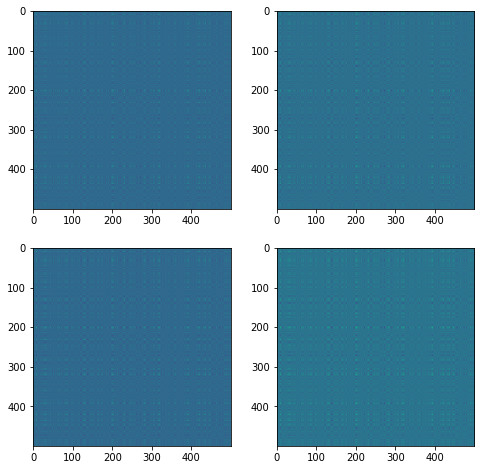

In [28]:
%matplotlib inline
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.imshow(H_major_0_5)
plt.subplot(2, 2, 2)
plt.imshow(H_minor_0_5)
plt.subplot(2, 2, 3)
plt.imshow(H_major_0_99)
plt.subplot(2, 2, 4)
plt.imshow(H_minor_0_99)

In [ ]:
print(np.linalg.matrix_rank(H_minor_0_5 @ H_major_0_5))

In [27]:
print(np.linalg.matrix_rank(H_minor_0_99 @ H_major_0_99))

3


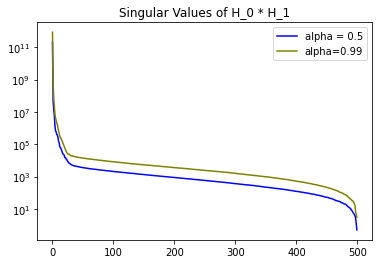

In [35]:
# TODO: look at singular values of H_minor.T @ H_major, for the two different values of alpha.
_, s_0_5, _ = np.linalg.svd(H_minor_0_5 @ H_major_0_5)
_, s_0_99, _ = np.linalg.svd(H_minor_0_99 @ H_major_0_99)
plt.plot(s_0_5, color='blue', label='alpha = 0.5')
plt.plot(s_0_99, color='olive', label='alpha=0.99')
plt.yscale('log')
plt.title("Singular Values of H_0 * H_1")
plt.legend()

In [33]:
print("H_minor rank, alpha = 0.5: {}".format(np.linalg.matrix_rank(H_minor_0_5)))
print("H_major rank, alpha = 0.5: {}".format(np.linalg.matrix_rank(H_major_0_5)))
print("H_minor * H_major rank, alpha = 0.5: {}".format(np.linalg.matrix_rank(H_minor_0_5 @ H_major_0_5)))

print("H_minor rank, alpha = 0.99: {}".format(np.linalg.matrix_rank(H_minor_0_99)))
print("H_major rank, alpha = 0.99: {}".format(np.linalg.matrix_rank(H_major_0_99)))
print("H_minor * H_major rank, alpha = 0.99: {}".format(np.linalg.matrix_rank(H_minor_0_99 @ H_major_0_99)))

H_minor rank, alpha = 0.5: 59
H_major rank, alpha = 0.5: 71
H_minor * H_major rank, alpha = 0.5: 3
H_minor rank, alpha = 0.99: 49
H_major rank, alpha = 0.99: 57
H_minor * H_major rank, alpha = 0.99: 3
